In [40]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders.equity_pricing_loader import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing

In [41]:
import pandas as pd

from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities

In [42]:
from zipline.data import bundles
import os

In [64]:
import matplotlib.pyplot as plt

In [43]:
#os.environ['ZIPLINE_ROOT'] = r'C:\Users\leo_s\.zipline'
os.environ['ZIPLINE_ROOT'] = '/home/hao/.zipline/'

In [44]:
start_session = pd.Timestamp('2016-5-9', tz = 'utc')
end_session = pd.Timestamp('2019-5-9', tz = 'utc')

register(
	'cryptocompare_cryptocurrencies',
	csvdir_equities(
		['daily'], 
		'/home/hao/Documents/trading_strats/data/', 
		), 
	calendar_name = '24/7',
	start_session = start_session,
	end_session = end_session
	)

/home/hao/anaconda3/envs/env_zipline/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Overwriting bundle with name 'cryptocompare_cryptocurrencies'
  if sys.path[0] == '':


<bound method CSVDIRBundle.ingest of <zipline.data.bundles.csvdir.CSVDIRBundle object at 0x7fcc66e55128>>

In [45]:
bundle_data = bundles.load('cryptocompare_cryptocurrencies')

In [46]:
#symbols = ['BTC', 'ETH']
#crypto_assets = []
#for ticker in symbols:
    #crypto_assets.append(bundle_data.asset_finder.lookup_symbol(ticker, end_session))

In [47]:
universe = AverageDollarVolume(window_length = 30).top(30) 
trading_calendar = get_calendar('24/7') 

In [48]:
from zipline.pipeline.factors import CustomFactor
from sklearn.linear_model import LinearRegression

class RegressionAgainstTime(CustomFactor):

    #TODO: choose a window length that spans one year's worth of trading days
    window_length = 60
    
    #TODO: use USEquityPricing's close price
    inputs = [USEquityPricing.close]
    
    #TODO: set outputs to a list of strings, which are names of the outputs
    #We're calculating regression coefficients for two independent variables, 
    # called beta and gamma
    outputs = ['beta', 'gamma']
    
    def compute(self, today, assets, out, dependent):
        
        #TODO: define an independent variable that represents time from the start to end
        # of the window length. E.g. [1,2,3...252]
        t1 = np.arange(self.window_length)
        
        #TODO: define a second independent variable that represents time ^2
        t2 = t1 ** 2
        
        # combine t1 and t2 into a 2D numpy array
        X = np.array([t1, t2]).T

    
        #TODO: the number of stocks is equal to the length of the "out" variable,
        # because the "out" variable has one element for each stock
        n_stocks = len(out)
        # loop over each asset

        for i in range(n_stocks):
            # TODO: "dependent" is a 2D numpy array that
            # has one stock series in each column,
            # and days are along the rows.
            # set y equal to all rows for column i of "dependent"
            y = dependent[:, i]
            
            # TODO: run a regression only if all values of y
            # are finite.
            if np.all(np.isfinite(y)) :
                # create a LinearRegression object
                regressor = LinearRegression()
                
                # TODO: fit the regressor on X and y
                regressor.fit(X, y)
                
                # store the beta coefficient
                out.beta[i] = regressor.coef_[0]
                
                #TODO: store the gamma coefficient
                out.gamma[i] = regressor.coef_[1]
            else:
                # store beta as not-a-number
                out.beta[i] = np.nan
                
                # TODO: store gammas not-a-number
                out.gamma[i] = np.nan


In [49]:
#Example: we'll call the RegressionAgainstTime constructor,
# pass in the "universe" variable as our mask, 
# and get the "beta" variable from that object.
# Then we'll get the rank based on the beta value.
beta_factor = (
    RegressionAgainstTime(mask=universe).beta.
    rank()
)

# TODO: similar to the beta factor,
# We'll create the gamma factor
gamma_factor = RegressionAgainstTime(mask = universe).gamma.rank()

# TODO: if we multiply the beta factor and gamma factor,
# we can then rank that product to create the conditional factor
conditional_factor = (beta_factor * gamma_factor).rank()

p = Pipeline(screen = universe)
# Add the beta, gamma and conditional factor to the pipeline
p.add(beta_factor, 'time_beta')
p.add(gamma_factor, 'time_gamma')
p.add(conditional_factor, 'conditional_factor')

In [50]:
# Very Useful Guidance on how to build the pipeline engine
import numpy as np

from zipline.assets._assets import Equity
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader


EOD_BUNDLE_NAME = 'cryptocompare_cryptocurrencies'


class PricingLoader(object):
    def __init__(self, bundle_data):
        self.loader = USEquityPricingLoader(
            bundle_data.equity_daily_bar_reader,
            bundle_data.adjustment_reader)

    def get_loader(self, column):
        if column not in USEquityPricing.columns:
            raise Exception('Column not in USEquityPricing')
        return self.loader


def build_pipeline_engine(bundle_data, trading_calendar):
    pricing_loader = PricingLoader(bundle_data)

    engine = SimplePipelineEngine(
        get_loader = pricing_loader.get_loader,
        calendar = trading_calendar.all_sessions,
        asset_finder = bundle_data.asset_finder)

    return engine

In [51]:
engine = build_pipeline_engine(bundle_data, trading_calendar)

In [52]:
pipeline_data = engine.run_pipeline(p, start_session + pd.DateOffset(days = 60), end_session)

In [53]:
pipeline_data

conditional_factor  time_beta  \
2016-07-08 00:00:00+00:00 Equity(0 [ABBC])                   NaN        NaN   
                          Equity(1 [ADA])                    NaN        NaN   
                          Equity(2 [AOA])                    NaN        NaN   
                          Equity(3 [BAT])                    NaN        NaN   
                          Equity(4 [BCD])                    NaN        NaN   
                          Equity(5 [BCH])                    NaN        NaN   
                          Equity(6 [BEC])                    NaN        NaN   
                          Equity(7 [BNB])                    NaN        NaN   
                          Equity(8 [BSV])                    NaN        NaN   
                          Equity(9 [BTC])                    2.0        8.0   
                          Equity(10 [BTG])                   NaN        NaN   
                          Equity(11 [DASH])                  5.0        6.0   
                          Equity(12 [DCR])                   8.0        4.0   
                          Equity(13 [DOGE])                  NaN        NaN   
                          Equity(14 [EOS])                   NaN        NaN   
                          Equity(15 [ETC])                   NaN        NaN   
                          Equity(16 [ETH])                   4.0        7.0   
                          Equity(17 [GNO])                   NaN        NaN   
                          Equity(18 [HT])                    NaN        NaN   
                          Equity(19 [IOST])                  NaN        NaN   
                          Equity(20 [KBC])                   NaN        NaN   
                          Equity(21 [KCS])                   NaN        NaN   
                          Equity(22 [LINK])                  NaN        NaN   
                          Equity(23 [LSK])                   NaN        NaN   
                          Equity(24 [LTC])                   6.0        5.0   
                          Equity(25 [MCO])                   NaN        NaN   
                          Equity(39 [WAVES])                 NaN        NaN   
                          Equity(40 [XEM])                   1.0        1.0   
                          Equity(43 [XMR])                   7.0        3.0   
                          Equity(44 [XRP])                   3.0        2.0   
...                                                          ...        ...   
2019-05-09 00:00:00+00:00 Equity(3 [BAT])                    7.0        4.0   
                          Equity(5 [BCH])                    5.0       29.0   
                          Equity(7 [BNB])                   29.0       18.0   
                          Equity(8 [BSV])                   16.0       22.0   
                          Equity(9 [BTC])                    1.0       30.0   
                          Equity(10 [BTG])                  30.0       16.0   
                          Equity(11 [DASH])                  8.0       27.0   
                          Equity(12 [DCR])                  27.0       20.0   
                          Equity(14 [EOS])                  23.0       14.0   
                          Equity(15 [ETC])                  24.0       15.0   
                          Equity(16 [ETH])                  12.0       26.0   
                          Equity(17 [GNO])                  21.0       19.0   
                          Equity(18 [HT])                   17.0        9.0   
                          Equity(21 [KCS])                  22.0       11.0   
                          Equity(22 [LINK])                  6.0        3.0   
                          Equity(23 [LSK])                  25.0       10.0   
                          Equity(24 [LTC])                  10.0       25.0   
                          Equity(25 [MCO])                  19.0        8.0   
                          Equity(26 [MKR])                   3.0       28.0   
                 

In [54]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar = trading_calendar,
    first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader = None,
    equity_daily_reader = bundle_data.equity_daily_bar_reader,
    adjustment_reader = bundle_data.adjustment_reader)

In [55]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

In [84]:
import alphalens as al

def make_factor_data(df, data_portal, trading_calendar, start_date, end_date):
    assets = df.index.levels[1].values.tolist()
    df = df.dropna()
    pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets,
        start_date,
        end_date,
        'close'
    )
    
    factor_names = df.columns
    factor_data = {}

    for factor in factor_names:
        print("Formatting factor data for: " + factor)
        factor_data[factor] = al.utils.get_clean_factor_and_forward_returns(
            factor = df[factor],
            prices = pricing,
            periods = [28]
        )
    
    return factor_data['time_beta']

In [85]:
factor_data = make_factor_data(pipeline_data, data_portal, trading_calendar, start_session, end_session)

/home/hao/anaconda3/envs/env_zipline/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/home/hao/anaconda3/envs/env_zipline/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


Formatting factor data for: conditional_factor
Dropped 3.7% entries from factor data: 3.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_beta
Dropped 3.7% entries from factor data: 3.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_gamma
Dropped 3.7% entries from factor data: 3.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [95]:
# Modified from alphalens source code

def create_factor_charts(factor_data, long_short=True, group_neutral=False, by_group=False):

    factor_returns = al.performance.factor_returns(factor_data, long_short, group_neutral)

    mean_quant_ret, std_quantile = al.performance.mean_return_by_quantile(factor_data, by_group = False, 
                                                                          demeaned = long_short, 
                                                                          group_adjust = group_neutral)

    mean_quant_rateret = mean_quant_ret.apply(al.utils.rate_of_return, axis = 0, 
                                              base_period = mean_quant_ret.columns[0])

    mean_quant_ret_bydate, std_quant_daily = al.performance.mean_return_by_quantile(factor_data, by_date = True, 
                                                                                    by_group = False, demeaned = long_short, 
                                                                                    group_adjust = group_neutral)

    mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(al.utils.rate_of_return, axis = 0, 
                                                            base_period = mean_quant_ret_bydate.columns[0])

    compstd_quant_daily = std_quant_daily.apply(al.utils.std_conversion, axis = 0, 
                                                base_period=std_quant_daily.columns[0])

    alpha_beta = al.performance.factor_alpha_beta(factor_data, factor_returns, 
                                                  long_short, group_neutral)

    mean_ret_spread_quant, std_spread_quant = al.performance.compute_mean_returns_spread(mean_quant_rateret_bydate, 
                                                                                         factor_data['factor_quantile'].max(), 
                                                                                         factor_data['factor_quantile'].min(), 
                                                                                         std_err=compstd_quant_daily)


    al.plotting.plot_returns_table(alpha_beta, mean_quant_rateret, mean_ret_spread_quant)
    al.plotting.plot_quantile_returns_bar(mean_quant_rateret, by_group=False, ylim_percentiles=None)
    plt.savefig('/home/hao/Documents/trading_strats/inputs/return_chart_1.jpg')

    trading_calendar = factor_data.index.levels[0].freq
    if trading_calendar is None:
        trading_calendar = pd.tseries.offsets.BDay()
        warnings.warn(
            "'freq' not set in factor_data index: assuming business day",
            UserWarning
        )

    for p in factor_returns:

        title = ('Factor Weighted '
                 + ('Group Neutral ' if group_neutral else '')
                 + ('Long/Short ' if long_short else '')
                 + "Portfolio Cumulative Return ({} Period)".format(p))

        al.plotting.plot_cumulative_returns(factor_returns[p], period=p, freq=trading_calendar, title=title)
        plt.savefig('/home/hao/Documents/trading_strats/inputs/return_chart_2.jpg')
        al.plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate[p], period=p, freq=trading_calendar)
        plt.savefig('/home/hao/Documents/trading_strats/inputs/return_chart_3.jpg')
        
    plt.show()

Returns Analysis


,28D
Ann. alpha,0.410
beta,0.003
Mean Period Wise Return Top Quantile (bps),256.895
Mean Period Wise Return Bottom Quantile (bps),-680.490
Mean Period Wise Spread (bps),937.385


/home/hao/anaconda3/envs/env_zipline/lib/python3.5/site-packages/pandas/core/indexes/datetimes.py:840: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
/home/hao/anaconda3/envs/env_zipline/lib/python3.5/site-packages/alphalens/performance.py:455: RuntimeWarning: invalid value encountered in double_scalars
  return ((np.nansum(ret) + 1)**(1. / period)) - 1


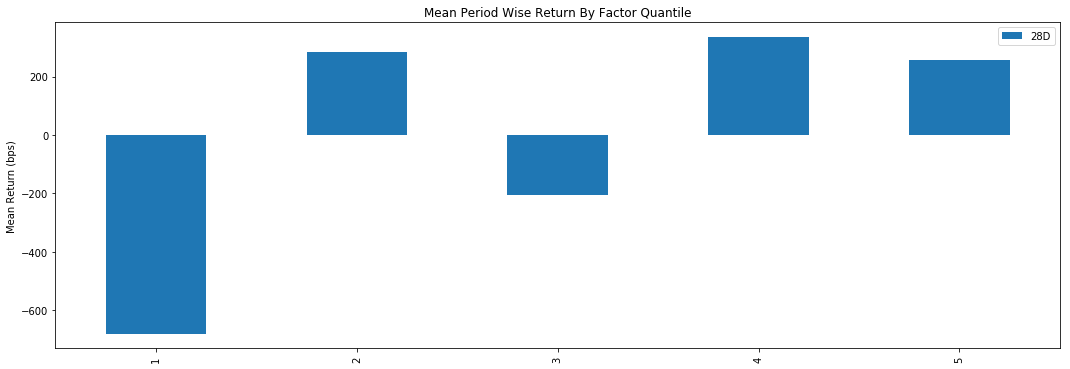

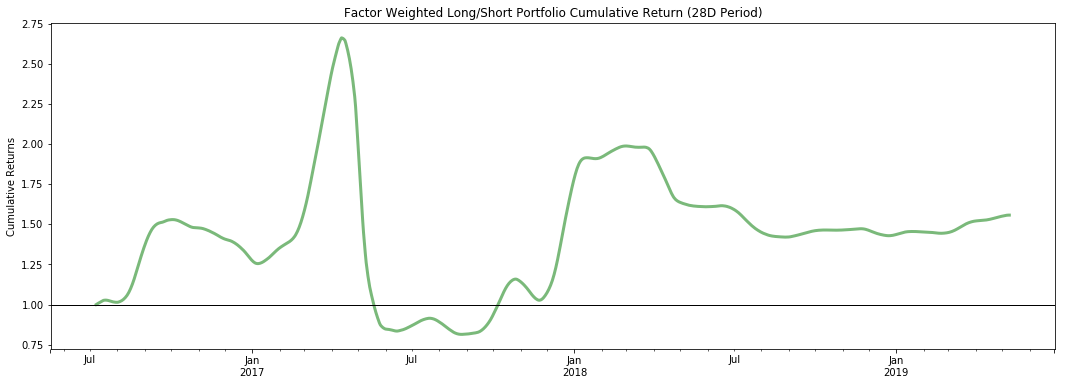

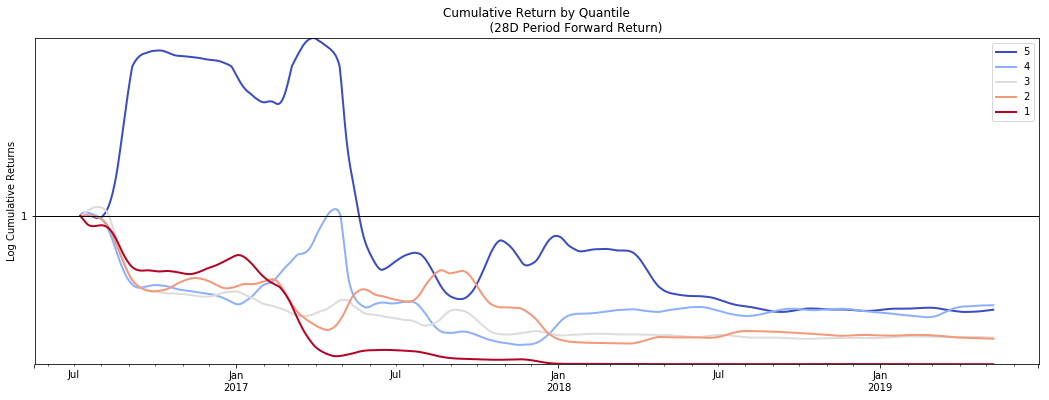

In [96]:
create_factor_charts(factor_data)

In [56]:
import time
import alphalens as al

def make_factor_plot(df, data_portal, trading_calendar, start_date, end_date):
    assets = df.index.levels[1].values.tolist()
    df = df.dropna()
    pricing = get_pricing(
        data_portal,
        trading_calendar,
        assets,
        start_date,
        end_date,
        'close'
    )
    
    factor_names = df.columns
    factor_data = {}

    start_time = time.clock()
    for factor in factor_names:
        print("Formatting factor data for: " + factor)
        factor_data[factor] = al.utils.get_clean_factor_and_forward_returns(
            factor = df[factor],
            prices = pricing,
            periods = [1]
        )
    end_time = time.clock()
    print("Time to get arrange factor data: %.2f secs" % (end_time - start_time))
    
    ls_factor_returns = []

    start_time = time.clock()
    for i, factor in enumerate(factor_names):
        ls = al.performance.factor_returns(factor_data[factor])
        ls.columns = [factor]
        ls_factor_returns.append(ls)
    end_time = time.clock()
    print("Time to generate long/short returns: %.2f secs" % (end_time - start_time))

    df_ls_factor_returns = pd.concat(ls_factor_returns, axis = 1)
    (1 + df_ls_factor_returns).cumprod().plot(title = 'Factor Returns');
    return df_ls_factor_returns

/home/hao/anaconda3/envs/env_zipline/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/home/hao/anaconda3/envs/env_zipline/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


Formatting factor data for: conditional_factor
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_beta
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: time_gamma
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 3.30 secs
Time to generate long/short returns: 2.24 secs


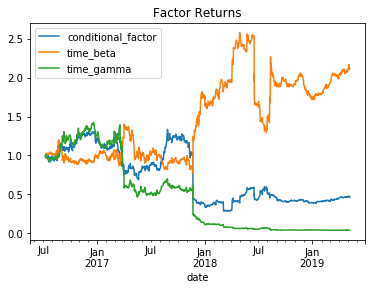

In [60]:
factor_plot = make_factor_plot(pipeline_data, data_portal, trading_calendar, start_session, end_session)

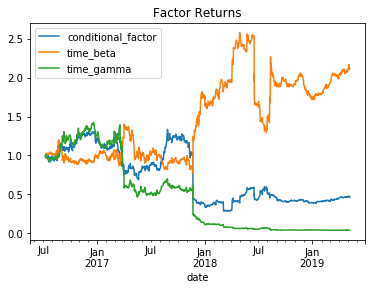

In [66]:
(1 + factor_plot).cumprod().plot(title = 'Factor Returns')
plt.savefig('/home/hao/Documents/trading_strats/inputs/factor_returns_plot.png')